In [56]:
import os
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.neural_network import MLPClassifier

from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline
from sklearn.model_selection import PredefinedSplit

from xgboost import XGBClassifier
from sklearn.impute import SimpleImputer

In [37]:
SEED = 42
np.random.seed(SEED)

DATA_DIR = "../Data"

# Covertype
COV_TRAIN = os.path.join(DATA_DIR, "covtype_train.csv")
COV_TEST  = os.path.join(DATA_DIR, "covtype_test.csv")

# HELOC
HELOC_TRAIN = os.path.join(DATA_DIR, "heloc_train.csv")
HELOC_TEST  = os.path.join(DATA_DIR, "heloc_test.csv")

# HIGGS
HIGGS_TRAIN = os.path.join(DATA_DIR, "higgs_train.csv")
HIGGS_TEST  = os.path.join(DATA_DIR, "higgs_test.csv")


print("Covertype train:", COV_TRAIN)
print("HELOC train:", HELOC_TRAIN)
print("HIGGS train:", HIGGS_TRAIN)

Covertype train: ../Data/covtype_train.csv
HELOC train: ../Data/heloc_train.csv
HIGGS train: ../Data/higgs_train.csv


In [38]:
def load_covertype():
    df_train = pd.read_csv(COV_TRAIN)
    df_test = pd.read_csv(COV_TEST)
    # df_train.describe()

    X_train = df_train.drop(columns=["Cover_Type"])
    X_test = df_test
    y_train = df_train["Cover_Type"].values

    y_series = pd.Series(y_train)
    print(y_series.value_counts().sort_index())

    # No missing data to handle

    return X_train, y_train, X_test


X_cov_train, y_cov_train, X_cov_test = load_covertype()

print("CoverType:", X_cov_train.shape, y_cov_train.shape)
print("CoverType test:", X_cov_test.shape)


display(X_cov_train)

1    21297
2    28248
3     3607
4      259
5      932
6     1706
7     2052
Name: count, dtype: int64
CoverType: (58101, 54) (58101,)
CoverType test: (3500, 54)


,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Horizontal_Distance_To_Fire_Points,...,Soil_Type31,Soil_Type32,Soil_Type33,Soil_Type34,Soil_Type35,Soil_Type36,Soil_Type37,Soil_Type38,Soil_Type39,Soil_Type40
0,3351,206,27,726,124,3813,192,252,180,2271,...,0,0,0,0,0,0,0,1,0,0
1,2732,129,7,212,1,1082,231,236,137,912,...,0,0,0,0,0,0,0,0,0,0
2,2572,24,9,201,25,957,216,222,142,2191,...,0,0,0,0,0,0,0,0,0,0
3,2824,69,13,417,39,3223,233,214,110,6478,...,0,0,0,0,0,0,0,0,0,0
4,2529,84,5,120,9,1092,227,231,139,4983,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
58096,3160,315,8,0,0,1366,199,234,174,1129,...,0,0,0,0,0,0,0,0,0,0
58097,2607,45,12,242,52,977,223,214,123,1342,...,0,0,0,0,0,0,0,0,0,0
58098,2317,280,25,190,64,433,144,233,225,582,...,0,0,0,0,0,0,0,0,0,0
58099,3183,89,17,60,8,3443,243,211,91,443,...,0,0,0,0,0,0,0,0,0,0


In [7]:
def load_heloc():

    df_train = pd.read_csv(HELOC_TRAIN)
    df_test  = pd.read_csv(HELOC_TEST)

    # Label: good = 1, bad  = 0
    y = (df_train["RiskPerformance"] == "Bad").astype(int).values
    X = df_train.drop(columns=["RiskPerformance"]).astype(np.float32)
    X_test = df_test.copy().astype(np.float32)

    # Replace sentinel codes with NaN
    X = X.replace([-7, -8, -9], np.nan)
    X_test = X_test.replace([-7, -8, -9], np.nan)
    return X, y, X_test


X_heloc_train, y_heloc_train, X_heloc_test = load_heloc()

print("HELOC Train:", X_heloc_train.shape, y_heloc_train.shape)
print("HELOC Test:", X_heloc_test.shape)

y_heloc_series = pd.Series(y_heloc_train)
print(y_heloc_series.value_counts().sort_index())

X_heloc_train

HELOC Train: (9413, 23) (9413,)
HELOC Test: (1046, 23)
0    4488
1    4925
Name: count, dtype: int64


,ExternalRiskEstimate,MSinceOldestTradeOpen,MSinceMostRecentTradeOpen,AverageMInFile,NumSatisfactoryTrades,NumTrades60Ever2DerogPubRec,NumTrades90Ever2DerogPubRec,PercentTradesNeverDelq,MSinceMostRecentDelq,MaxDelq2PublicRecLast12M,...,PercentInstallTrades,MSinceMostRecentInqexcl7days,NumInqLast6M,NumInqLast6Mexcl7days,NetFractionRevolvingBurden,NetFractionInstallBurden,NumRevolvingTradesWBalance,NumInstallTradesWBalance,NumBank2NatlTradesWHighUtilization,PercentTradesWBalance
0,69.0,148.0,4.0,66.0,41.0,0.0,0.0,100.0,15.0,7.0,...,10.0,0.0,1.0,1.0,32.0,60.0,7.0,3.0,1.0,50.0
1,77.0,229.0,3.0,109.0,23.0,0.0,0.0,100.0,15.0,7.0,...,35.0,0.0,0.0,0.0,38.0,93.0,4.0,3.0,1.0,58.0
2,58.0,46.0,7.0,38.0,13.0,0.0,0.0,93.0,8.0,4.0,...,50.0,0.0,2.0,2.0,80.0,84.0,5.0,4.0,1.0,90.0
3,72.0,186.0,6.0,76.0,20.0,0.0,0.0,97.0,15.0,6.0,...,33.0,0.0,1.0,1.0,30.0,73.0,3.0,2.0,1.0,67.0
4,80.0,226.0,2.0,66.0,35.0,0.0,0.0,100.0,15.0,7.0,...,47.0,0.0,0.0,0.0,2.0,77.0,5.0,7.0,0.0,62.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9408,65.0,115.0,11.0,43.0,19.0,0.0,0.0,90.0,1.0,4.0,...,50.0,0.0,0.0,0.0,52.0,77.0,5.0,6.0,0.0,85.0
9409,77.0,437.0,8.0,115.0,35.0,0.0,0.0,100.0,15.0,7.0,...,26.0,1.0,3.0,3.0,23.0,74.0,6.0,2.0,0.0,50.0
9410,75.0,140.0,7.0,56.0,21.0,0.0,0.0,100.0,15.0,7.0,...,27.0,0.0,1.0,1.0,20.0,63.0,3.0,2.0,1.0,56.0
9411,64.0,92.0,3.0,35.0,21.0,2.0,2.0,91.0,33.0,6.0,...,23.0,0.0,1.0,1.0,9.0,58.0,3.0,4.0,0.0,53.0


In [ ]:
# from EDA.eda_covtype import X_train_enc

def load_higgs():

    df_train = pd.read_csv(HIGGS_TRAIN)
    df_test  = pd.read_csv(HIGGS_TEST)


    y_train = df_train["Label"]
    y_train = (y_train == "s").astype(int).values

    w_train = df_train["Weight"].values.astype(np.float32)
 
    # Features: drop ID, Weight, label columns
    drop_cols = [c for c in ["EventId", "Weight", "Label", "label"] if c in df_train.columns]
    feature_cols = [c for c in df_train.columns if c not in drop_cols]

    X_train = df_train[feature_cols].copy()
    X_test = df_test[feature_cols].copy()


    # Replace -999.0 with NaN
    X_train = X_train.replace(-999.0, np.nan)
    X_test = X_test.replace(-999.0, np.nan)

    return X_train, y_train, w_train, X_test 

X_higgs_train, y_higgs_train, w_higgs_train, X_higgs_test = load_higgs()


print("HIGGS:", X_higgs_train.shape, y_higgs_train.shape)
print(len(w_higgs_train))

HIGGS: (175000, 30) (175000,)
175000


In [3]:

# Why labels 0–10 (disjoint label space)?
# - We train a SINGLE-head classifier (one softmax over all classes).
# - Therefore every numeric class id must have ONE meaning across the entire training set.
# - CoverType has 7 classes -> map to 0..6.
# - HELOC and HIGGS are binary but have different semantics -> they must NOT reuse 0/1.
#   So we shift them into new ids: HELOC -> 7..8, HIGGS -> 9..10.

# Why NOT 0–7 + dataset column?
# - If multiple datasets share label ids (e.g., 0/1), the target becomes ambiguous for a single-head model.
# - A dataset indicator helps features, but does not change the fact that class-id semantics would collide.
# - If you want overlapping label ids, you need a MULTI-HEAD model (separate outputs per dataset/task) or separate models.

# Why Chose this model?

# Choices for a model
# -HELOC: Logistic Regression (interpretable), RandomForest/LightGBM/XGBoost, maybe TabPFN.
# -CoverType: LightGBM/XGBoost, RandomForest.
# -HIGGS: Gradient boosting (LightGBM/XGBoost) or something that scales well.

# If we combine the RandomForrest, X

In [55]:
# Calculate dimensions first (needed for embed_block function)
d_cov = X_cov_train.shape[1]
d_heloc = X_heloc_train.shape[1]
d_higgs = X_higgs_train.shape[1]

D_total = d_cov + d_heloc + d_higgs + 3

def embed_block(X, index, dimensions):
    """Place a dataset's features into its slice of the unified space.

    dataset_idx: 0 = CoverType, 1 = HELOC, 2 = HIGGS
    """
    # Number of rows in de X trainingset:
    n_samples = X.shape[0]


    embedded = np.zeros((n_samples, dimensions), dtype=np.float32)

    def set_index(index):
        if index == 0:
            return 0, d_cov
        elif index == 1:
            return d_cov, d_cov + d_heloc
        elif index == 2: 
            return d_cov + d_heloc, d_cov + d_heloc + d_higgs

    start, end = set_index(index)

    embedded[:, start:end] = X

    # Dataset indicator in the final 3 positions
    embedded[:, D_total - 3 + index] = 1
    return embedded

# Label the target columns to avoid collisions across datasets
cov_unique = np.sort(np.unique(y_cov_train))
cov_map = {v: i for i, v in enumerate(cov_unique)}
y_cov_int = np.array([cov_map[v] for v in y_cov_train], dtype=np.int64)     # 0..6

y_heloc_int = y_heloc_train.astype(np.int64) + 7                            # 7,8
y_higgs_int = y_higgs_train.astype(np.int64) + 9                            # 9,10

# Embed features (train)
X_cov_emb   = embed_block(X_cov_train, 0, D_total)
X_heloc_emb = embed_block(X_heloc_train, 1, D_total)
X_higgs_emb = embed_block(X_higgs_train, 2, D_total)


# Embed features (test) – needed for the submission step
X_cov_test_emb   = embed_block(X_cov_test, 0, D_total)
X_heloc_test_emb = embed_block(X_heloc_test, 1, D_total)
X_higgs_test_emb = embed_block(X_higgs_test, 2, D_total)

# # Stack the datasets on top of each other
X_train = np.vstack([X_cov_emb, X_heloc_emb, X_higgs_emb])
y_train = np.concatenate([y_cov_int, y_heloc_int, y_higgs_int])
# y_train is a numpy array; np.bincount gives class counts
print("Total target distribution:", pd.Series(y_train).value_counts().sort_index())

w_cov_train = np.ones_like(y_cov_train, dtype=np.float32)
w_heloc_train = np.ones_like(y_heloc_train, dtype=np.float32)
w_train = np.concatenate([w_cov_train, w_heloc_train, w_higgs_train])

# Statistics of the dataset
print(f"X_cov shape:   {X_cov_train.shape}")
print(f"X_heloc shape: {X_heloc_train.shape}")
print(f"X_higgs shape: {X_higgs_train.shape}")

print(f"Rows total X:   {X_cov_train.shape[0] + X_heloc_train.shape[0] + X_higgs_train.shape[0]}")
print("\n" + "="*30 + "\n")

# Check the shape of all the y
print(f"y_cov shape:   {y_cov_train.shape}")
print(f"y_heloc shape: {y_heloc_train.shape}")
print(f"y_higgs shape: {y_higgs_train.shape}")

print(f"Rows total y:   {y_cov_train.shape[0] + y_heloc_train.shape[0] + y_higgs_train.shape[0]}")
print("\n" + "="*30 + "\n")


print(f"X_total shape: {X_train.shape}")
print(f"y_total shape: {y_train.shape}")
print(f"w_total_shape: {len(w_train)}")
print(w_train.mean())

Total target distribution: 0      21297
1      28248
2       3607
3        259
4        932
5       1706
6       2052
7       4488
8       4925
9     115214
10     59786
Name: count, dtype: int64
X_cov shape:   (58101, 54)
X_heloc shape: (9413, 23)
X_higgs shape: (175000, 30)
Rows total X:   242514


y_cov shape:   (58101,)
y_heloc shape: (9413,)
y_higgs shape: (175000,)
Rows total y:   242514


X_total shape: (242514, 110)
y_total shape: (242514,)
w_total_shape: 242514
1.4681339


In [ ]:
def get_scaler_options():
    return {
        "standard": StandardScaler(), 
        "minmax": MinMaxScaler(), 
        "robust": RobustScaler(), 
        "none": None,
    }


def config_smote_strategy(y, smote_ratio, max_upsample_factor=5.0):
    counts = pd.Series(y).value_counts()
    print(counts)
    max_count = counts.max()
    target_count = int(max_count * smote_ratio)
    
    smote_strategy = {}
    for cls in counts.index:
        original_count = counts[cls]
        if original_count < target_count:
            # Cap at max_upsample_factor * original_count
            capped_target = min(target_count, int(original_count * max_upsample_factor))
            smote_strategy[cls] = capped_target
    
    return smote_strategy, counts

In [88]:
def train_model(model_name, X, y, imputer, smote_ratio, scaler_type, use_grid, test_size):

    # 1. Stratified Split
    X_train, X_val, y_train, y_val = train_test_split(
        X, y, test_size=test_size, random_state=42, stratify=y
    )

    # 2. Setup Scaler & SMOTE
    scaler_map = get_scaler_options()
    smote_strategy, counts = config_smote_strategy(y_train, smote_ratio)
    if scaler_map is None:
        scaler_choics = 'passthrough'
    else:
        scaler_choics = None

    # 3. Define Classifier
    if model_name == "mlp":
        classifier = MLPClassifier(
            hidden_layer_sizes=(128, 128),
            activation="relu", solver="adam",
            alpha=1e-4, 
            batch_size=512, 
            learning_rate_init=1e-3,
            max_iter=20,
            early_stopping=True, 
            n_iter_no_change=10, 
            random_state=42, 
            verbose=False
        )
    elif model_name == "xgb":
        classifier = XGBClassifier(
            n_estimators=300,  
            max_depth=6, 
            learning_rate=0.05,
            subsample=0.8, 
            colsample_bytree=0.8, 
            objective="multi:softprob",
            tree_method="hist", 
            random_state=42, 
            n_jobs=-1
        )


    pipeline = ImbPipeline([
        ('imputer', SimpleImputer(strategy=imputer)),
        ('scaler', scaler_choics), 
        ('smote', SMOTE(sampling_strategy=smote_strategy, random_state=42, k_neighbors=3)),
        ('classifier', classifier)
    ])

    # 5.Manual Grid Search Loop
    if use_grid:
        param_grids = {
            "mlp": {
                "classifier__hidden_layer_sizes": [(128, 128), (256, 256)],
                "classifier__alpha": [1e-4, 1e-3],
                "classifier__learning_rate_init": [1e-3],
                "smote__k_neighbors": [3, 5] 
            },
            "xgb": {
                "classifier__n_estimators": [300, 500],
                "classifier__max_depth": [5, 7],
                "classifier__learning_rate": [0.05],
                "smote__k_neighbors": [5]
            }
        }
        
        X_combined = np.vstack([X_train, X_val])
        y_combined = np.concatenate([y_train, y_val])

        # -1 = training, 0 = validation 
        split_index = [-1] * len(X_train) + [0] * len(X_val)
        cv = PredefinedSplit(test_fold=split_index)
        
        model = GridSearchCV(
            pipeline,
            param_grid=param_grids[model_name],
            cv=cv,
            scoring='f1_weighted',
            n_jobs=-1,
            verbose=1,
            refit=True
        )
        model.fit(X_combined, y_combined)
        print(f"\nBest params: {model.best_params_}")
        print(f"Best validation score: {model.best_score_:.4f}")
    else:
        model = pipeline
        model.fit(X_train, y_train)


    return model, X_val, y_val

In [109]:
model_name = "xgb"
imputer = "median"
smote_ratio = 0.8
scaler_type = None
use_grid = False
test_size = 0.2

model, X_val, y_val = train_model(model_name, X_train, y_train, imputer, smote_ratio, scaler_type, use_grid, test_size)

print(model)

9     92171
10    47829
1     22598
0     17037
8      3940
7      3590
2      2886
6      1642
5      1365
4       746
3       207
Name: count, dtype: int64
Pipeline(steps=[('imputer', SimpleImputer(strategy='median')), ('scaler', None),
                ('smote',
                 SMOTE(k_neighbors=3, random_state=42,
                       sampling_strategy={0: 73736, 1: 73736, 2: 14430, 3: 1035,
                                          4: 3730, 5: 6825, 6: 8210, 7: 17950,
                                          8: 19700, 10: 73736})),
                ('classifier',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_by...
                               feature_types=None, feature_weights=None,
                               gamma=None, grow_policy=None,
                               importance_type=None,
                               in

(242514, 110)

(48503, 110)

(242514,)

(48503,)

For the whole dataset
Accuracy: 0.7871
Precision: 0.7980
Recall: 0.7871


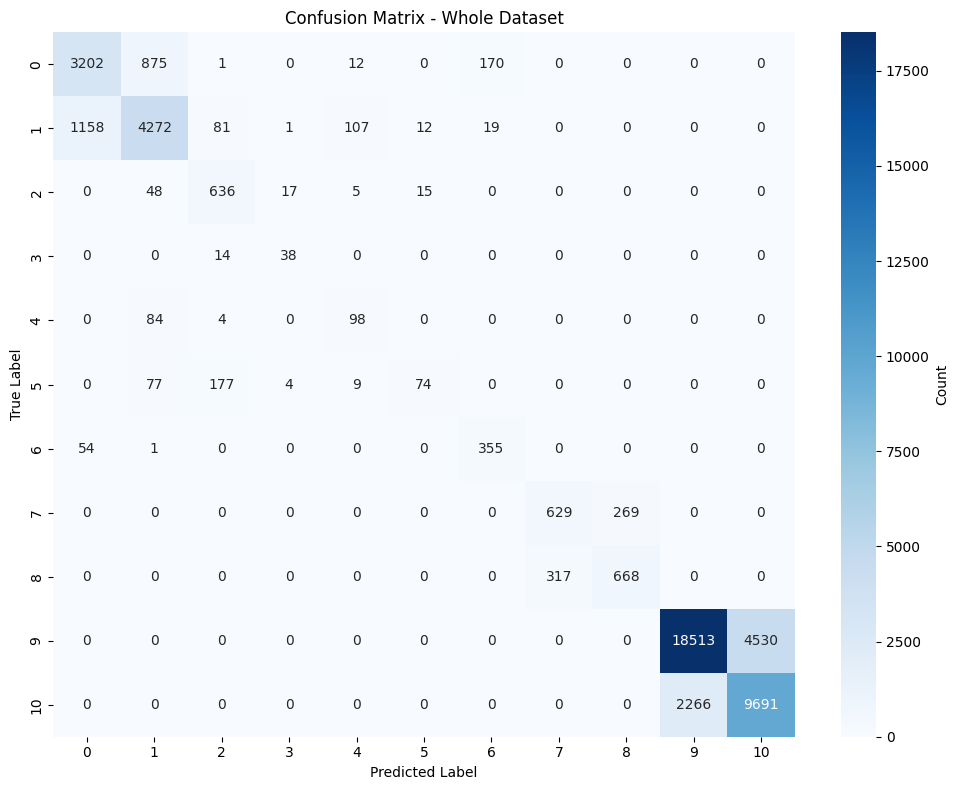


CoverType:
Accuracy: 0.7443
Precision: 0.7511
Recall: 0.7443


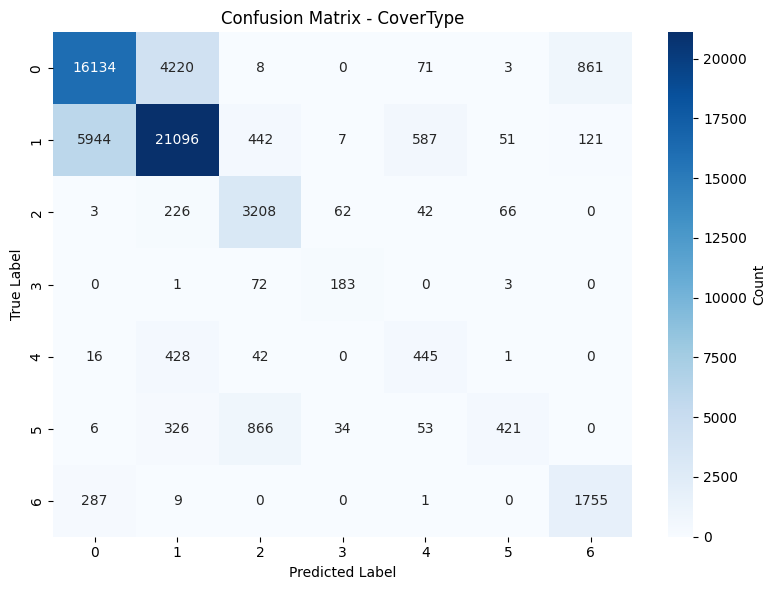


HELOC:
Accuracy: 0.7359
Precision: 0.7370
Recall: 0.7359


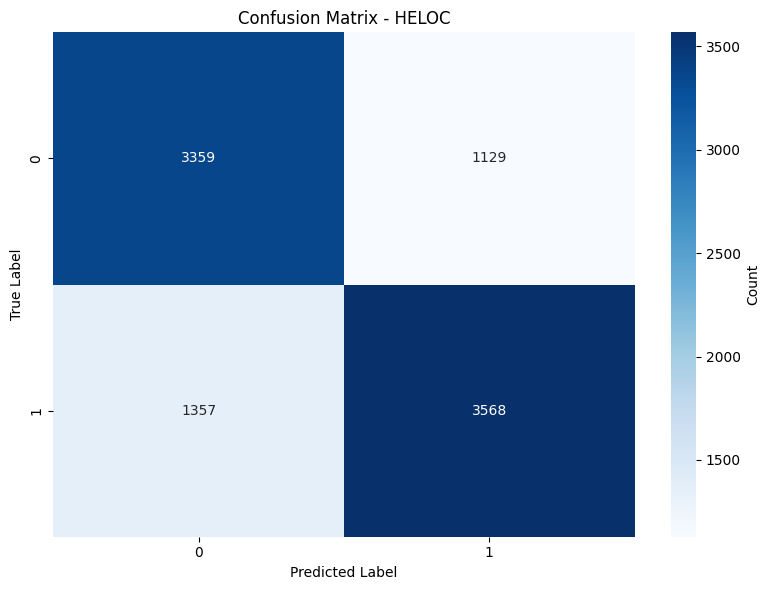


HIGGS:
Accuracy: 0.8122
Precision: 0.8257
Recall: 0.8122


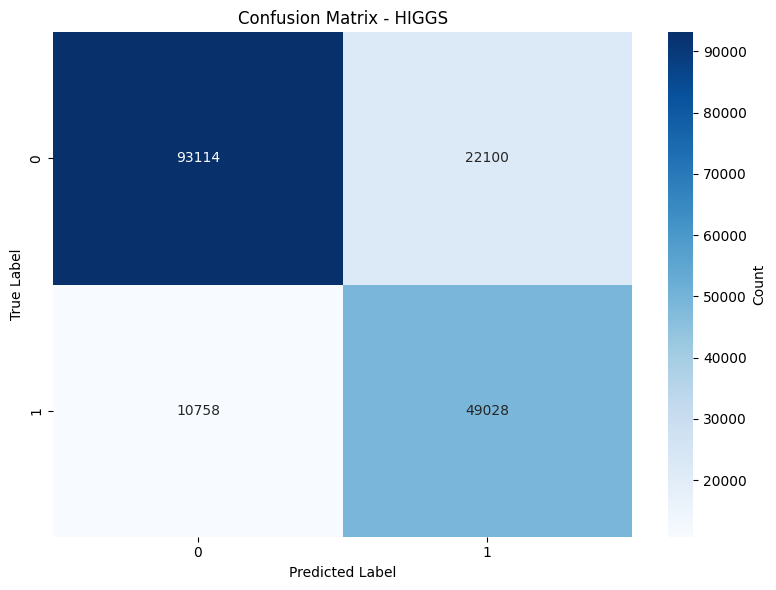

In [105]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

def evaluate_whole_dataset(model, X, y_true):
    print("For the whole dataset")
    y_pred = model.predict(X)

    accuracy = accuracy_score(y_true, y_pred)
    print(f"Accuracy: {accuracy:.4f}")

    precision = precision_score(y_true, y_pred, average='weighted', zero_division=0)
    print(f"Precision: {precision:.4f}")

    recall = recall_score(y_true, y_pred, average='weighted', zero_division=0)
    print(f"Recall: {recall:.4f}")

    # Confusion Matrix
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar_kws={'label': 'Count'})
    plt.title('Confusion Matrix - Whole Dataset')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.tight_layout()
    plt.show()

    


def evaluate_individual_dataset(model, X, y_true, name):
    print(f"\n{name}:")
    y_pred = model.predict(X)

    accuracy = accuracy_score(y_true, y_pred)
    print(f"Accuracy: {accuracy:.4f}")

    precision = precision_score(y_true, y_pred, average='weighted', zero_division=0)
    print(f"Precision: {precision:.4f}")

    recall = recall_score(y_true, y_pred, average='weighted', zero_division=0)
    print(f"Recall: {recall:.4f}")

    # Confusion Matrix
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar_kws={'label': 'Count'})
    plt.title(f'Confusion Matrix - {name}')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.tight_layout()
    plt.show()

display(X_train.shape)
display(X_val.shape)
display(y_train.shape)
display(y_val.shape)

whole_metrics = evaluate_whole_dataset(model, X_val, y_val)

cov_metrics = evaluate_individual_dataset(model, X_cov_emb, y_cov_int, "CoverType")
heloc_metrics = evaluate_individual_dataset(model, X_heloc_emb, y_heloc_int, "HELOC")
higgs_metrics = evaluate_individual_dataset(model, X_higgs_emb, y_higgs_int, "HIGGS")


In [106]:
# Reverse mapping for predictions
# CoverType: 0-6 -> 1-7
inverse_cov_map = {v: k for k, v in cov_map.items()}

# Get predictions from model
y_cov_test_pred = model.predict(X_cov_test_emb)
y_heloc_test_pred = model.predict(X_heloc_test_emb)
y_higgs_test_pred = model.predict(X_higgs_test_emb)

# Convert predictions back to original label space
# CoverType: 0-6 -> 1-7 (with fallback for out-of-range predictions)
y_cov_test_pred_orig = np.array([
    inverse_cov_map.get(pred, max(inverse_cov_map.values())) 
    for pred in y_cov_test_pred
])

# HELOC: 7, 8 -> 0, 1 (with fallback for out-of-range predictions)
y_heloc_test_pred_orig = np.array([
    int(pred - 7) if 7 <= pred <= 8 else 0 
    for pred in y_heloc_test_pred
])

# HIGGS: 9, 10 -> 0, 1 (with fallback for out-of-range predictions)
y_higgs_test_pred_orig = np.array([
    int(pred - 9) if 9 <= pred <= 10 else 0 
    for pred in y_higgs_test_pred
])

print("CoverType predictions (original labels 1-7):", np.unique(y_cov_test_pred_orig))
print("HELOC predictions (original labels 0-1):", np.unique(y_heloc_test_pred_orig))
print("HIGGS predictions (original labels 0-1):", np.unique(y_higgs_test_pred_orig))


CoverType predictions (original labels 1-7): [1 2 3 4 5 6 7]
HELOC predictions (original labels 0-1): [0 1]
HIGGS predictions (original labels 0-1): [0 1]


In [107]:

# Generate submission file with original label encoding

# CoverType: IDs start at 1
cov_df = pd.DataFrame({
    "ID": np.arange(1, 1 + len(y_cov_test_pred_orig)),
    "Prediction": y_cov_test_pred_orig
})

# HELOC: IDs start at 3501
heloc_start = 3501
heloc_df = pd.DataFrame({
    "ID": np.arange(heloc_start, heloc_start + len(y_heloc_test_pred_orig)),
    "Prediction": y_heloc_test_pred_orig
})

# HIGGS: IDs start at 4547
higgs_start = 4547
higgs_df = pd.DataFrame({
    "ID": np.arange(higgs_start, higgs_start + len(y_higgs_test_pred_orig)),
    "Prediction": y_higgs_test_pred_orig
})

# Merge all into one CSV
submission = pd.concat([cov_df, heloc_df, higgs_df], ignore_index=True)

print("\nSubmission preview:")
print(submission.head(10))
print("...")
print(submission.tail(10))
print(f"\nTotal rows: {len(submission)}")

# Save
submission_path = "combined_submission.csv"
submission.to_csv(submission_path, index=False)

print(f"Saved")



Submission preview:
   ID  Prediction
0   1           1
1   2           1
2   3           1
3   4           2
4   5           1
5   6           1
6   7           1
7   8           2
8   9           2
9  10           2
...
          ID  Prediction
79536  79537           1
79537  79538           1
79538  79539           0
79539  79540           0
79540  79541           1
79541  79542           1
79542  79543           0
79543  79544           0
79544  79545           1
79545  79546           0

Total rows: 79546
Saved
